# Entanglement in Action

In [1]:
from qiskit import __version__
print(__version__)

1.3.2


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from numpy import pi, random

## Teleportation

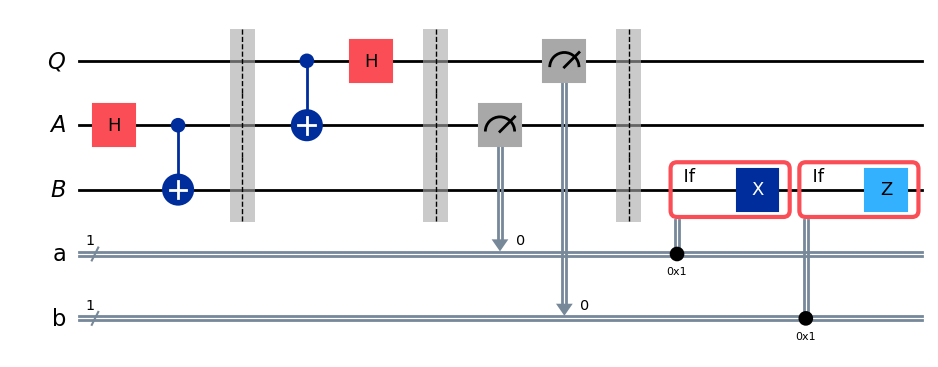

In [3]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Initialize A and B to the Phi(+) state
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Perform Alice's operations on A and Q
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and send classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output="mpl"))

Note that the `barrier` function creates a visual separation making the circuit more readable, **and it also prevents Qiskit from performing various simplifications and optimizations accross the barrier during compilation when circuits are run on real hardware.** The `if_test` function applies an operation conditionally depending on a classical bit or register.

To test that the protocol works correctlly, we'll apply a randomly generated single-qubit gate to the initialized $|0\rangle$ state of Q to obtain a random quantum state vector to be teleported. Then, by applying the inverse of that gate to B after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $|0\rangle$ state.

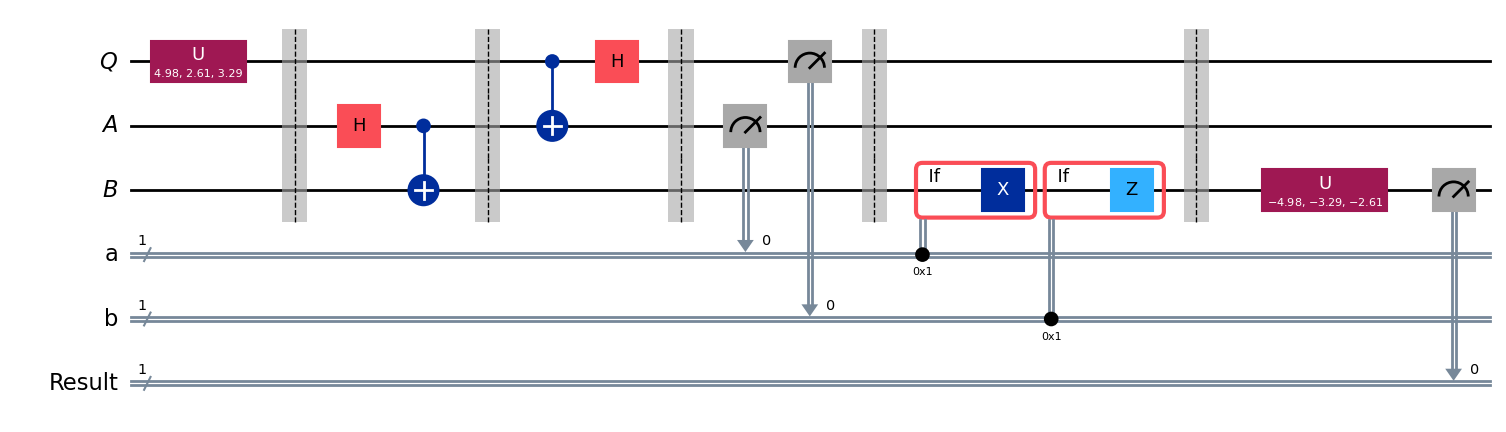

In [4]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi
)

# Create a test circuit including the same bits/qubits above
test = QuantumCircuit(qubit, ebit0, ebit1, a, b,)

# Apply the randomly generated gate to Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# Apply the inverse of the random unitary operation to B
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output="mpl"))

Finally, we can run the Aer Simulator on the circuit and plot a histogram of the outputs:

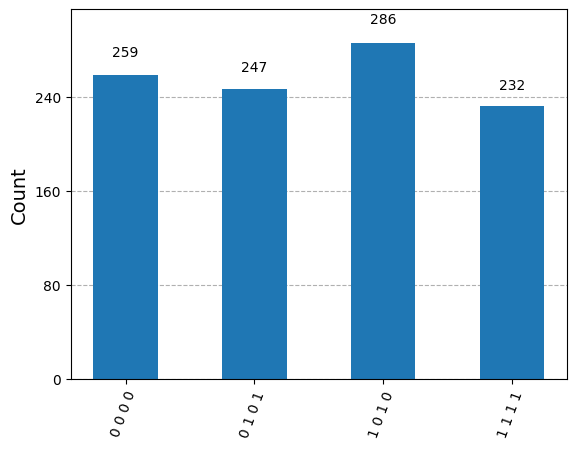

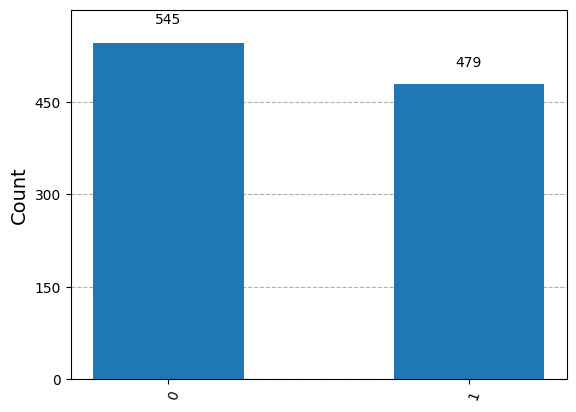

In [13]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

# Filter the statistics to focus on the test result qubit
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

## Superdense Coding

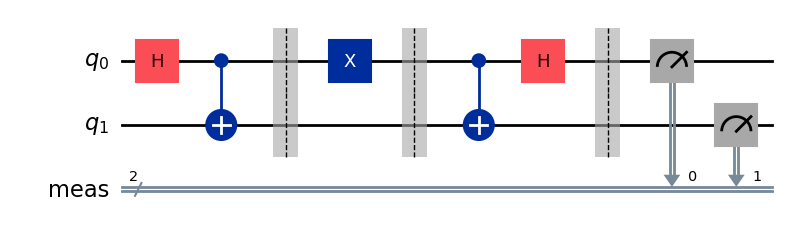

In [6]:
# Arbitrary choice of two classical bits
c = "1"
d = "0"

# Build the circuit according to the protocol
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw(output="mpl"))

Note that the `measure_all` function measures all of the qubits and puts the results into a single classical register.

Measured 10 with frequency 1024


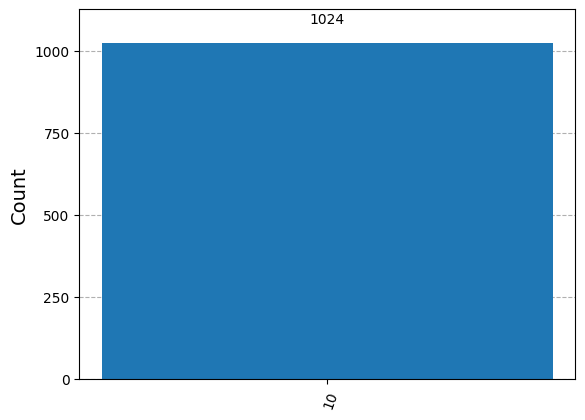

In [7]:
# Run the Aer Simulator
result = AerSimulator().run(protocol).result()
statistics = result.get_counts()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

We will now use an additional qubit as a random bit generator to randomally choose *c* and *d*.

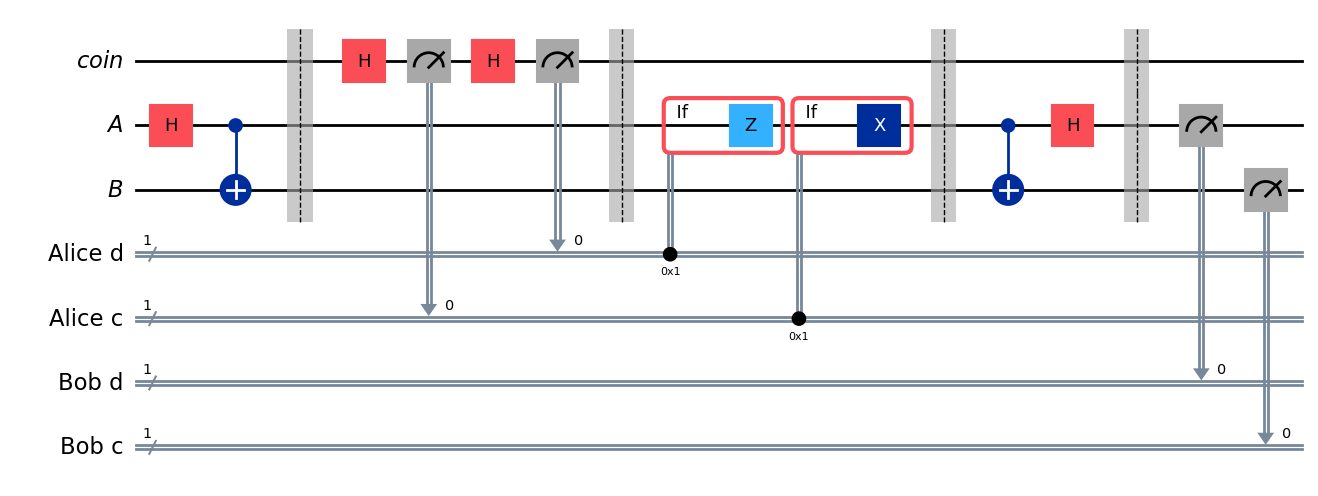

In [18]:
rbg = QuantumRegister(1, "coin")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the random qubit twice to generate Alice's bits c and d
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Run the protocol, starting with Alice's actions
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output="mpl"))

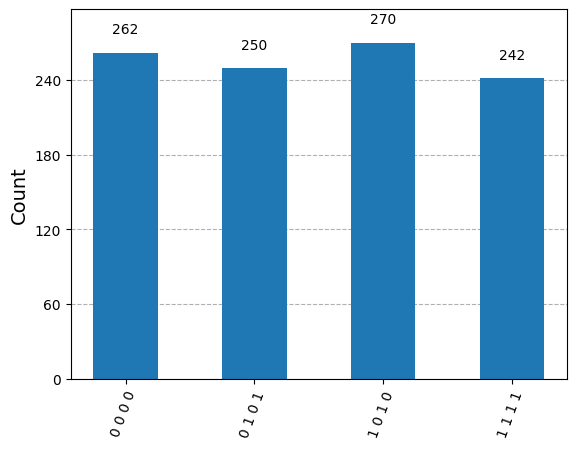

In [9]:
# Run the Aer Simulator
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

## The CHSH game

(x,y) = (0,0)


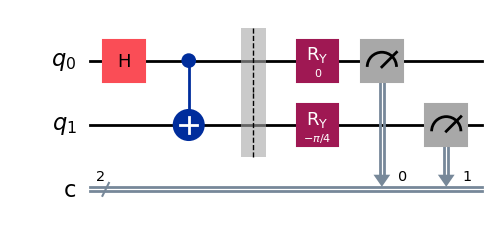

(x,y) = (0,1)


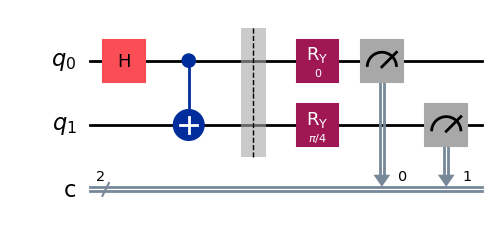

(x,y) = (1,0)


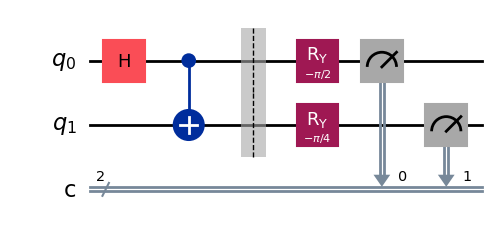

(x,y) = (1,1)


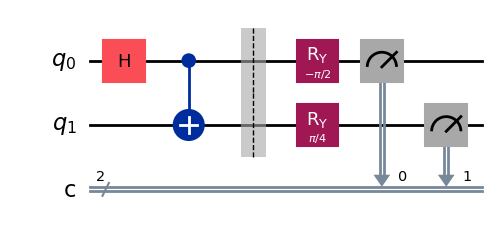

In [7]:
# Run the CHSH game, unsing the 'strategy' function from two bits to
# two bits; returns 1 for a win and 0 for a loss
def chsh_game(strategy):
    # Choose x and y randomly
    x, y = random.randint(0, 2), random.randint(0, 2)

    # Use the strategy to determine a and b
    a, b = strategy(x, y)

    # Decide if the strategy wins or loses
    if (a != b) == (x & y):
        return 1
    return 0

# Create a QuantumCircuit implementation of the quantum strategy 
# (including e-bit preparation) 
def chsh_circuit(x, y):
    qc = QuantumCircuit(2, 2)

    # Prepare an e-bit
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice's actions
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob's actions
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

# Draw the four possible circuits
print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw(output="mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw(output="mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw(output="mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw(output="mpl"))

In [5]:
# Run the appropiate quantum circuit one time and return the result
def quantum_strategy(x, y):
    # Setting `shots=1` to run the circuit once
    result = AerSimulator().run(chsh_circuit(x, y), shots=1).result()
    statistics = result.get_counts()

    # Determine the output bits and return them
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]

    return a, b

# Play th game 1000 times and compute the fraction of them that the strategy wins
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.862


In [6]:
# One example of an optimal classical strategy for the CHSH game
def classical_strategy(x, y):
    #Alice's answer
    if x == 0: 
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y== 1:
        b = 0

    return a, b

# Play th game 1000 times and compute the fraction of them that the strategy wins
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy) 

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.743
